**Name: Krish Murjani | N Number: N10121101 | NetID: km6520**

### **AI CS-GY-6613 Assignment 2A**

# **Dog Cat Classifier**

### **1. Import everything required**

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

### **2. Directory Setup**

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_dir = '/kaggle/input/dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")

Using device: cuda
Training directory: /kaggle/input/dogscats/subset/train
Validation directory: /kaggle/input/dogscats/subset/validation


### **3. Model Definition**

In [76]:
class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),  
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = DogCatClassifier().to(device)
print(model)

DogCatClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10368, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)


### **4. Loss Function and Optimizer**

In [77]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

### **5. Data Preprocessing and Loading**

In [78]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20)

### **6. Training Loop with 30 Epochs**

In [79]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels.float()).item()
            predicted_val = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%')

Epoch [1/30], Train Loss: 0.6942, Train Accuracy: 49.90%, Val Loss: 0.6916, Val Accuracy: 58.40%
Epoch [2/30], Train Loss: 0.6909, Train Accuracy: 53.25%, Val Loss: 0.6789, Val Accuracy: 61.90%
Epoch [3/30], Train Loss: 0.6715, Train Accuracy: 58.55%, Val Loss: 0.6785, Val Accuracy: 56.20%
Epoch [4/30], Train Loss: 0.6373, Train Accuracy: 64.60%, Val Loss: 0.6174, Val Accuracy: 66.10%
Epoch [5/30], Train Loss: 0.5992, Train Accuracy: 69.25%, Val Loss: 0.6231, Val Accuracy: 64.10%
Epoch [6/30], Train Loss: 0.5716, Train Accuracy: 70.10%, Val Loss: 0.5793, Val Accuracy: 68.70%
Epoch [7/30], Train Loss: 0.5451, Train Accuracy: 72.85%, Val Loss: 0.5768, Val Accuracy: 68.90%
Epoch [8/30], Train Loss: 0.5294, Train Accuracy: 73.80%, Val Loss: 0.5639, Val Accuracy: 70.80%
Epoch [9/30], Train Loss: 0.5170, Train Accuracy: 74.70%, Val Loss: 0.5888, Val Accuracy: 69.60%
Epoch [10/30], Train Loss: 0.5067, Train Accuracy: 75.20%, Val Loss: 0.5550, Val Accuracy: 71.90%
Epoch [11/30], Train Loss: 0.

### **7. Visualize Training Results**

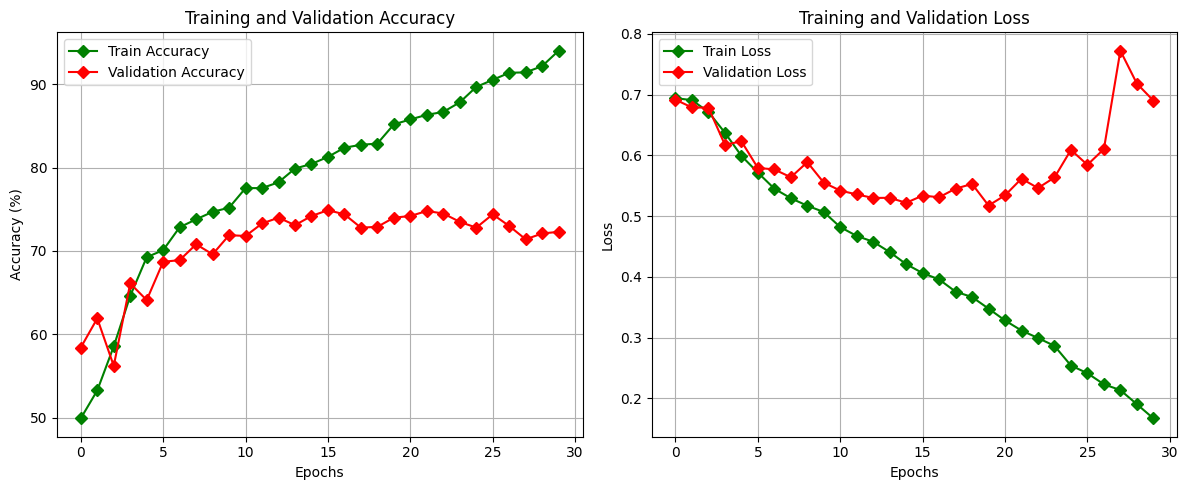

In [80]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='D', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', marker='D', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='D', color='green')
plt.plot(val_losses, label='Validation Loss', marker='D', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### **8. Save Model**

In [81]:
torch.save(model.state_dict(), 'dogcat_model.pth')

### **9. Data Augmentation and Visualization**

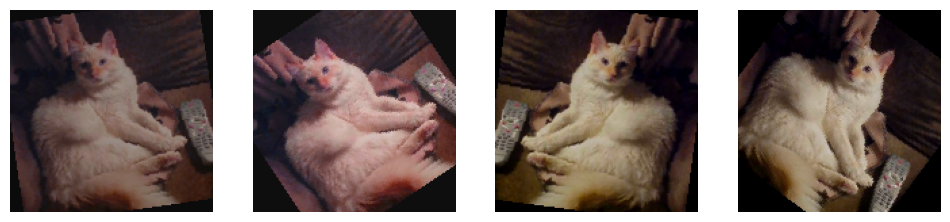

In [82]:
from PIL import Image
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

img_path = os.path.join(train_dir, 'cats', os.listdir(train_dir + '/cats')[3])
img = Image.open(img_path).convert("RGB")

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    augmented_image = data_transforms(img)
    img_array = augmented_image.numpy().transpose((1, 2, 0))
    axes[i].imshow(img_array)
    axes[i].axis('off')

plt.show()

### **10. Retrain the Model with Augmented Data and 100 Epochs**

In [83]:
train_transforms_aug = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

train_dataset_aug = datasets.ImageFolder(train_dir, transform=train_transforms_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

num_epochs_aug = 100
for epoch in range(num_epochs_aug):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_aug))
    train_accuracies.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch+1}/{num_epochs_aug}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')

Epoch [1/100], Train Loss: 0.7314, Train Accuracy: 61.35%
Epoch [2/100], Train Loss: 0.6333, Train Accuracy: 65.45%
Epoch [3/100], Train Loss: 0.6168, Train Accuracy: 66.40%
Epoch [4/100], Train Loss: 0.6136, Train Accuracy: 66.40%
Epoch [5/100], Train Loss: 0.6050, Train Accuracy: 68.10%
Epoch [6/100], Train Loss: 0.5879, Train Accuracy: 67.40%
Epoch [7/100], Train Loss: 0.5991, Train Accuracy: 68.40%
Epoch [8/100], Train Loss: 0.5881, Train Accuracy: 67.55%
Epoch [9/100], Train Loss: 0.5865, Train Accuracy: 67.80%
Epoch [10/100], Train Loss: 0.5825, Train Accuracy: 69.30%
Epoch [11/100], Train Loss: 0.5663, Train Accuracy: 70.40%
Epoch [12/100], Train Loss: 0.5725, Train Accuracy: 70.35%
Epoch [13/100], Train Loss: 0.5679, Train Accuracy: 70.35%
Epoch [14/100], Train Loss: 0.5378, Train Accuracy: 72.25%
Epoch [15/100], Train Loss: 0.5652, Train Accuracy: 70.90%
Epoch [16/100], Train Loss: 0.5567, Train Accuracy: 71.55%
Epoch [17/100], Train Loss: 0.5592, Train Accuracy: 71.40%
Epoch 

### **11. Save the New Model Separately**


In [84]:
torch.save(model.state_dict(), 'dogcat_model_augmented.pth')

### **12. Model Evaluation**

In [85]:
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_acc = evaluate(train_loader_aug, model)
val_acc = evaluate(val_loader, model)

print(f'Train Accuracy: {train_acc:.2f}')
print(f'Validation Accuracy: {val_acc:.2f}')

Train Accuracy: 0.83
Validation Accuracy: 0.83


### **13. Get Predictions**

In [86]:
def get_predictions(loader):
    all_predictions = []
    all_labels = []
    model.eval() 

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_labels), np.concatenate(all_predictions)

In [87]:
train_labels, train_predictions = get_predictions(train_loader_aug)
val_labels, val_predictions = get_predictions(val_loader)

### **14. Confusion Matrix and ROC Curve**

True Negatives:  409
False Positives:  91
False Negatives:  74
True Positives:  426
Total Detections:  500


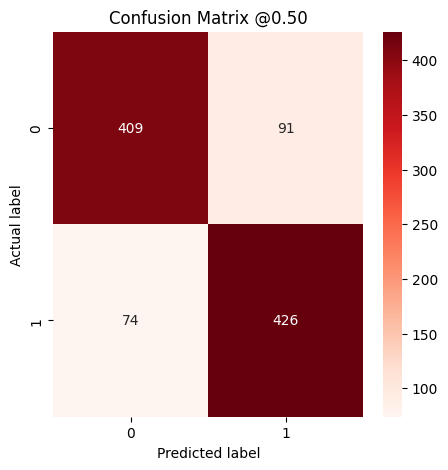

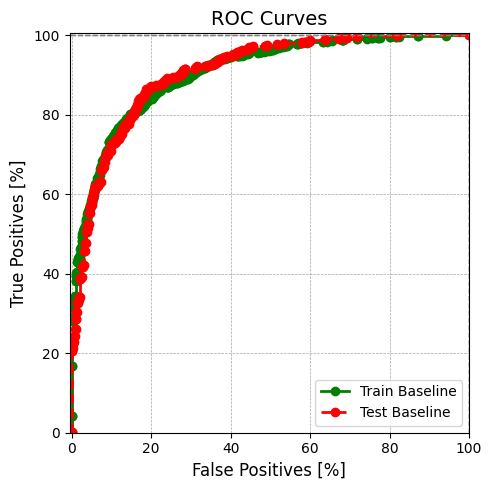

In [88]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Reds')
    plt.title('Confusion Matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Detections: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100 * fp, 100 * tp, label=name, marker='o', markersize=6, **kwargs)

    plt.xlabel('False Positives [%]', fontsize=12)
    plt.ylabel('True Positives [%]', fontsize=12)
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100.5])
    
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(y=100, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=100, color='gray', linestyle='--', linewidth=1)

plot_cm(val_labels, val_predictions)
plt.figure(figsize=(5,5)) 
plot_roc("Train Baseline", train_labels, train_predictions, color='green', linewidth=2)
plot_roc("Test Baseline", val_labels, val_predictions, linestyle='--', color='red', linewidth=2)

plt.legend(loc='lower right', fontsize=10)
plt.title('ROC Curves', fontsize=14)
plt.tight_layout()
plt.show()

# **CNN Explainability with Captum**

Captum is a library that provides interpretability for PyTorch models. We will specifically focus on two methods: Integrated Gradients and Layer Grad-CAM.

Firstly, ensure that Captum is installed:

In [89]:
pip install captum

Note: you may need to restart the kernel to use updated packages.


Some prerequisities:

1. Basic understanding of CNNs
2. PyTorch

### **Step 1: Import Required Libraries**

In [90]:
from captum.attr import IntegratedGradients
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

### **Step 2: Load a Sample Image**
We will load a sample image from our validation set. This image will be used for generating attributions using our explainer methods.

In [91]:
sample_image, _ = next(iter(val_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)

The image is preprocessed and moved to the appropriate device (e.g., GPU if available).

### **Step 3: Integrated Gradients Method**
Integrated Gradients is a method that helps to understand which parts of the input image contribute the most to the model's prediction.

Define an `IntegratedGradients` object and use it to generate attributions for our sample image.


In [92]:
integrated_gradients = IntegratedGradients(model)

### **Step 4: Model Prediction**

Get the model's prediction for the sample image before calculating the attributions.

In [93]:
model.eval()
pred_label_idx = model(sample_image).argmax(dim=1).item()

We set the model to evaluation mode and obtain the predicted class for the sample image.

### **Step 5: Compute Integrated Gradients Attributions**
Compute the attributions using the Integrated Gradients method for the target label identified earlier.

In [94]:
attributions_ig = integrated_gradients.attribute(sample_image, target=pred_label_idx, n_steps=200)

The `n_steps` parameter controls the number of steps to take while integrating, which helps in achieving smoother attributions.

### **Step 6: Visualize the Attributions**
Visualize the original image and the attributions computed using Integrated Gradients.

**Visualizing the Original Image**

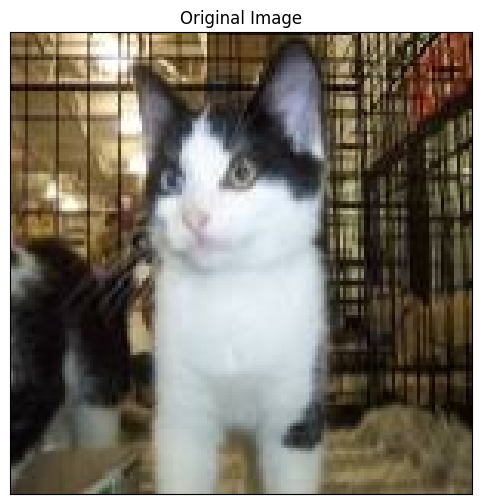

In [95]:
_ = viz.visualize_image_attr(
    None,
    sample_image.cpu().squeeze().permute(1, 2, 0).numpy(),
    method="original_image",
    title="Original Image"
)

### Visualizing Integrated Gradients Attributions
We define a custom color map and visualize the positive attributions that will indicate parts of the image that contributed positiv/ely to the prediction.

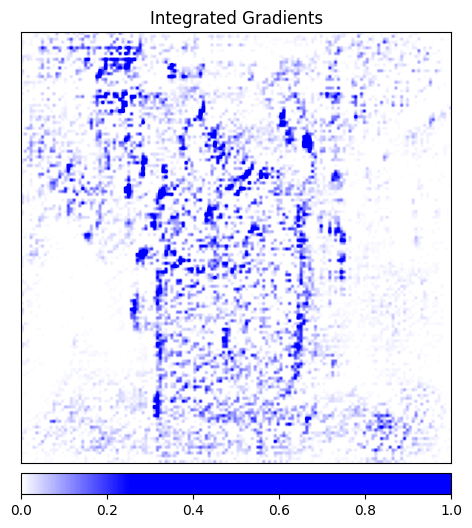

In [96]:
default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')], N=256
)

_ = viz.visualize_image_attr(
    attributions_ig.cpu().squeeze().permute(1, 2, 0).detach().numpy(),
    sample_image.cpu().squeeze().permute(1, 2, 0).numpy(),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    title='Integrated Gradients'
)

Positive regions are shown in shades of blue.

### **Step 7: Layer Grad-CAM Method**

Grad-CAM whcih is short for Gradient-weighted Class Activation Mapping provides visual explanations of where the model is looking when it makes a decision. 

It does this by using the gradients of a target concept flowing into the last convolutional layer to produce a "coarse" localization map.

### Define Layer Grad-CAM
Define a `LayerGradCam` object for a selected convolutional layer.

In [97]:
from captum.attr import LayerGradCam, LayerAttribution
import torch.nn.functional as F

layer_gradcam = LayerGradCam(model, model.model[4])  

### **Step 8: Compute Grad-CAM Attributions**

compute the attributions using Grad-CAM for the same image and target label.

In [98]:
attributions_lgc = layer_gradcam.attribute(sample_image, target=pred_label_idx)

### **Step 9: Upsample and Visualize Grad-CAM Attributions**

Since the attributions from Grad-CAM are smaller than the input image we need to upsample them for better visualization.

In [99]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, sample_image.shape[2:])

### Visualizing the Grad-CAM Heat Map
Visualize the upsampled Grad-CAM heatmap and blend it with the original image for better interpretability.

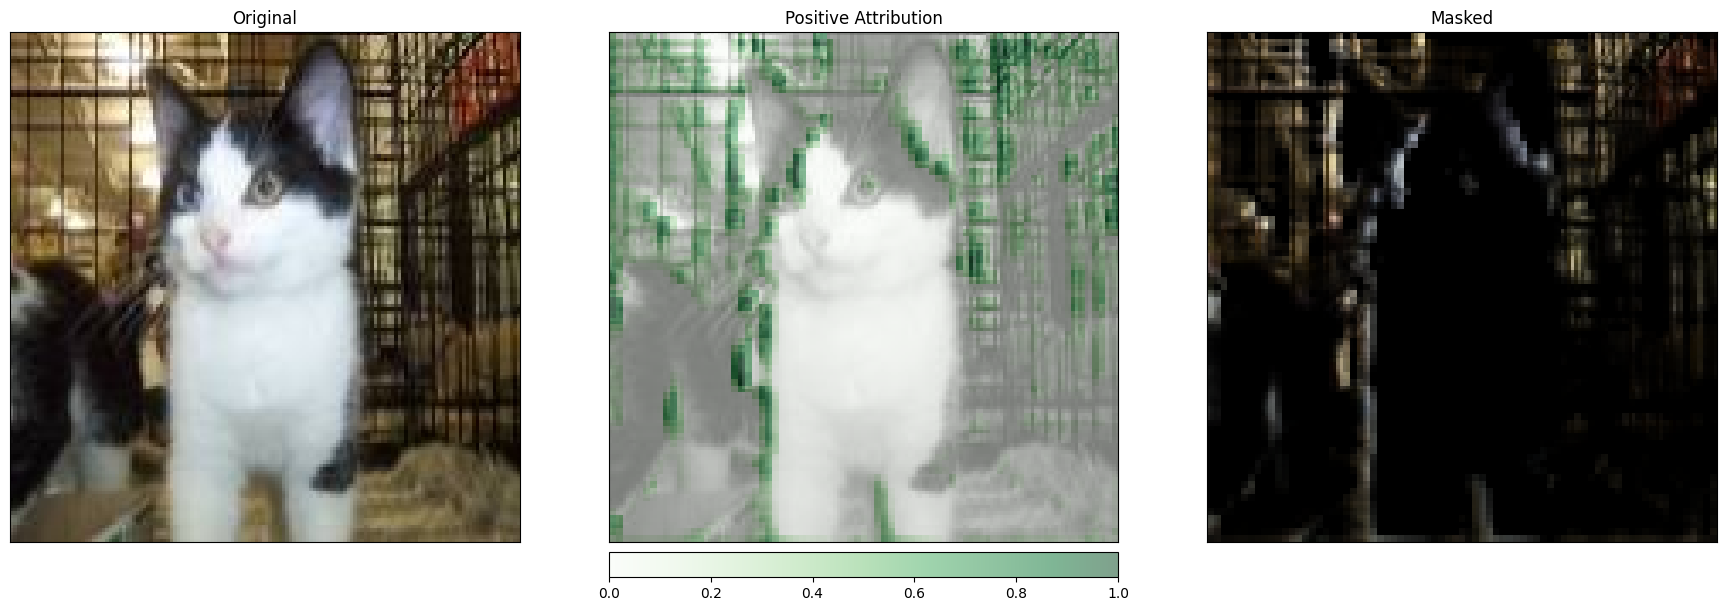

In [100]:
_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
    sample_image.cpu().squeeze().permute(1, 2, 0).numpy(),
    ["original_image", "blended_heat_map", "masked_image"],
    ["all", "positive", "positive"],
    show_colorbar=True,
    titles=["Original", "Positive Attribution", "Masked"],
    fig_size=(18, 6)
)


The blended heatmap provides a clear understanding of which regions of the image were considered by the model for its decision the most. It helps to see where the network is exactly "looking" when making a prediction.

### Saving the visualizations in png

In [101]:
import matplotlib.pyplot as plt

plt.imshow(sample_image.cpu().squeeze().permute(1, 2, 0).numpy())
plt.title("Original Image")
plt.axis('off')
plt.savefig("original_image.png", bbox_inches='tight')
plt.close()

plt.imshow(attributions_ig.cpu().squeeze().permute(1, 2, 0).detach().numpy(), cmap=default_cmap)
plt.title('Integrated Gradients')
plt.colorbar()
plt.axis('off')
plt.savefig("integrated_gradients.png", bbox_inches='tight')
plt.close()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(sample_image.cpu().squeeze().permute(1, 2, 0).numpy())
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(upsamp_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy(), cmap=default_cmap)
axes[1].set_title("Positive Attribution")
axes[1].axis('off')
plt.colorbar(axes[1].imshow(upsamp_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy(), cmap=default_cmap), ax=axes[1])

axes[2].imshow(sample_image.cpu().squeeze().permute(1, 2, 0).numpy())
axes[2].set_title("Masked")
axes[2].axis('off')

plt.savefig("multiple_attributions.png", bbox_inches='tight')
plt.close()


### Conclusion

We used **Integrated Gradients** and **Grad-CAM** to interpret CNN predictions with Captum. These methods help visualize the decision-making process of models.